In [1]:
import cv2
import os
import random
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow import keras
from Proj3_Utilies import plate_alignment
from IPython.display import clear_output

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, losses, models

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

In [3]:
def get_plate_digi(img,unet,cnn):
    t = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", 
     "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", 
     "学",'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 
     'U', 'V', 'W','X', 'Y', 'Z','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

    digis = []
    box = []
    
    img = np.array(img)/255
    img = img.reshape(1,512,512,3)

    y_pres = unet.predict(img)
    aligned_plate,un_aligned_plate,box, flag = plate_alignment(img[0],y_pres[0])

    if flag:
        aligned_plate = aligned_plate.reshape(1,80,240,3)

        digi_pres = cnn.predict(aligned_plate)
        digi_pres = np.array(digi_pres).reshape(7,68)
        digis = []
        for digi in digi_pres:
            digis.append(t[int(np.where(digi==np.max(digi))[0])])

    return digis, box, flag

In [4]:
keras.backend.clear_session()
unet = keras.models.load_model('./unet.h5')
cnn = keras.models.load_model('./cnn.h5')

6 image in total, 0 failed


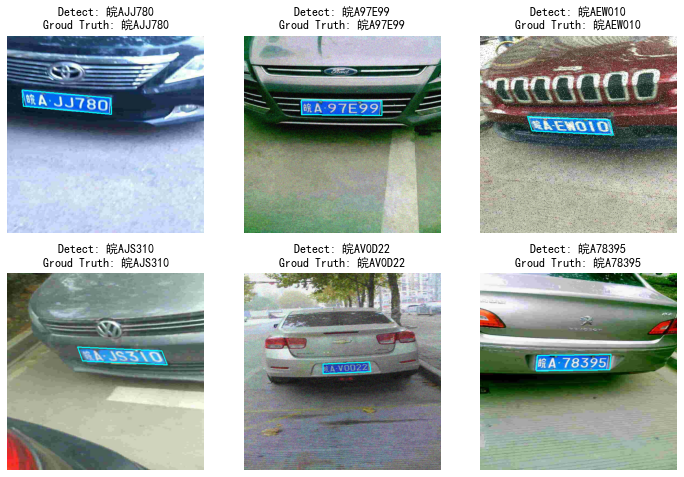

In [20]:
val_path = "./data_processed/validation/"
val_list = os.listdir(val_path)

val_img = []
val_label = []
pre_box = []
pre_label = []
failed_img = []

pick = random.sample(val_list,6)
for cur in pick:
    cur_img = cv2.imdecode(np.fromfile(val_path+cur, dtype=np.uint8), cv2.IMREAD_COLOR)
    cur_img = cv2.resize(cur_img,(512,512))
    cur_label = cur[:7]
    
    cur_pre_label, cur_pre_box, flag = get_plate_digi(cur_img,unet,cnn)
    
    if flag:
        pre_label.append("".join(cur_pre_label))
        pre_box.append(cur_pre_box)
        
        val_img.append(cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB))
        val_label.append(cur_label)
    else:
        failed_img.append(cur_img)
    
print("{} image in total, {} failed".format(len(pick),len(failed_img)))

plt.rcParams['font.sans-serif']=['SimHei']

fig = plt.figure(figsize=(12,8))
for i in range(len(val_img)):
    b = cv2.drawContours(val_img[i],[np.array(pre_box[i])], 0, (0, 255, 255), 2)
    title = "Detect: " + pre_label[i] + "\nGroud Truth: " + val_label[i]
    ax = fig.add_subplot(2,3,i+1)
    ax.imshow(b)
    ax.set_title(title)
    ax.axis('off')
plt.show()